# Wavelength Calibration
## Or, Wow, Steve, This Whole Python Thing Sounds Amazing, Maybe We Should Look Into It

### Part 1: The Spectrocalypse
It's the year 2098. Civilizations have fallen, disease spreads like wildfire, morale is at an all-time low.

*However*, you're so dedicated to your science that you still managed to take some spectra! Wow, look at you go. Impressive.

Wait. Not **that** impressive. You haven't even wavelength-calibrated them! Let's remedy that real quick. 

Well, what *is* wavelength calibration? Essentially, you are trying to find a way to map pixel units to physical wavelength units. You do this by finding lines for which you know the wavelength and can measure the pixel location.

#### NOTE: NEVER DO WAVELENGTH CALIBRATION ON AN UNREDUCED IMAGE.

It's bad and you should feel bad if you do it.

Anyway, here I'm going to show you a simple way to do this for a given spectrum. Again, let's start by importing the packages we'll need:

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from os import path
from astropy.io import ascii
from pylab import rcParams
%matplotlib inline

# preliminaries
rcParams['figure.figsize'] = (8, 8)
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

Remember that all your raw spectra are actually 2D images, so the 1st step is to turn those into 1D spectra.

Here, I'm going to assume that you've already done this. This means that, for a given image, you have a text file that has a list of pixels and the corresponding flux values at those pixels.

In `Python`, importing text files like this is very easy!

In [35]:
# import data
filepath = '/Users/luca/Documents/GradSchool/ASTR3130_2019/Lab6/'
name_1d = 'spectrum_calibration.dat'
file_1d = path.join(filepath, name_1d)

spectrum_lamps = ascii.read(file_1d)
spectrum_lamps  # look at ascii table formatting

col1,col2
float64,float64
1.0,1276.0
2.0,1286.0
3.0,1283.0
4.0,1284.0
5.0,1285.0
6.0,1291.0
7.0,1287.0
8.0,1289.0
9.0,1270.0


Ok, so it looks like `col1` is the pixel location, and `col2` is the actual spectrum. Let's parse this Table and plot the result:

Text(0,0.5,'Flux (ADU)')

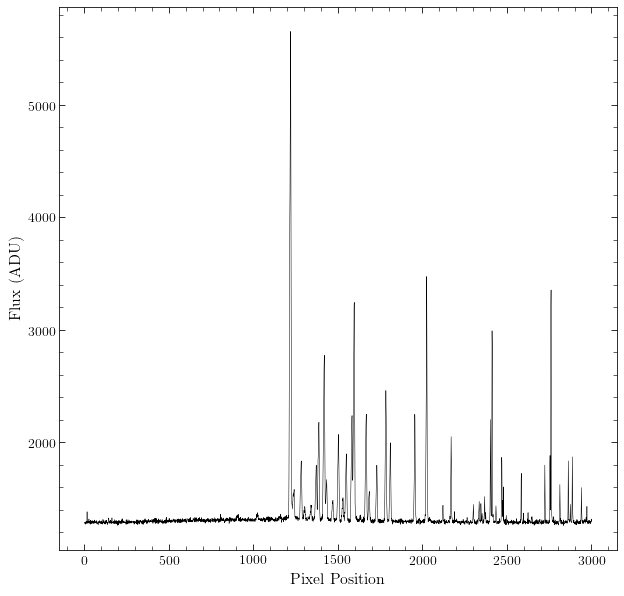

In [36]:
# parse
pix, flux = spectrum_lamps['col1'], spectrum_lamps['col2']

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(pix, flux, color='black', linewidth=0.5)
ax.set_xlabel('Pixel Position')
ax.set_ylabel('Flux (ADU)')

Look at those emission lines! This looks like it'll be very useful in wavelength calibration.

### Part 2: Poly Want a Well-Constrained Fit

There are many prescriptions for wavelength calibration in use. An easy one, and the one which we'll use, is to fit an $n^{\rm th}$ order polynomial to the data. For example, if $p$ is an array of pixel positions (and $\lambda$ is their corresponding physical wavelengths), we want to find a function $f:p \to \lambda$, where we can write

$f(p) = \sum\limits_{n} \left[ a_n\ p^n \right]$

The coefficients will be our fit parameters.

One issue with using very high-order polynomials in numerical analysis is something called **Runge's phenomenon**, and it boils down to the fact that you can fit an infinite amount of polynomials with large $n$ that fit 2 data points, but oscillate wildly inbetween. To mitigate this, we will restrict ourselves to a 3rd-order fit.

Now, if we're fitting a 3rd-order polynomial, we need at least 4 data points. This is an important fact, and it bears repeating:

**In order to fit an $n^{\rm th}$ order polynomial, you need at least $n+1$ data points.**

Otherwise, your fit is unconstrained and can vary wildly.

However, before we can do all that, we need to pick out some lines, and figure out their pixel positions! This is actually where you need to do a careful inspection of the spectrum and compare it to one labeled with known wavelengths.

For simplicity, I'm going to assume you've already done this, and you've stored the values as arrays.


(By this, I mean I'm going to make up some data)

In [29]:
# made up data
lambdas = np.array([5000, 5500, 6000, 7200])  # Angstroms
peaks = np.array([1264, 1464, 1641, 2071])  # pixels

`Python` provides a quick way to do polynomial fits with the `np.polyfit()` method. It returns the coefficients $a_n$, in decreasing order (e.g., [$a_n,\ a_{n-1}, ...$]). Let's make our fit:

In [13]:
# make fit function
coeffs = np.polyfit(peaks, lambdas, deg=3)
fitfunc = np.poly1d(coeffs)  # fitfunc is a callable function!

# test out fitfunc
print(fitfunc(peaks[0]))
print(fitfunc(500))

4999.999999999996
4680.5341679004805


Excellent! Let's take a quick look at the fit to make sure it makes sense:

Text(0,0.5,'Wavelength (\\AA)')

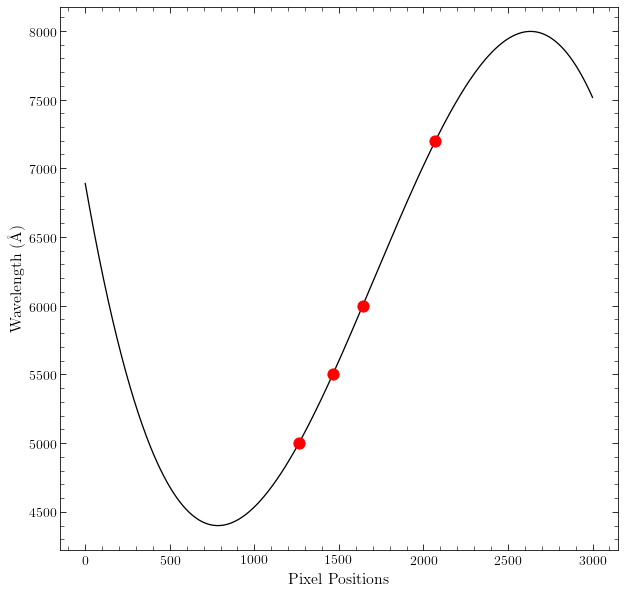

In [30]:
fitrange = np.linspace(0, 3000, 1000)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(peaks, lambdas, color='red', s=500, zorder=1)
ax.plot(fitrange, fitfunc(fitrange), color='black', linewidth=1.3, zorder=0)
ax.set_xlabel('Pixel Positions')
ax.set_ylabel('Wavelength (\\AA)')

Notice Runge's phenonemon at the outer edges. This highlights something important: when selecting your known emission lines, make sure to choose lines spanning the full wavelength range! (or at least as much as you can). Otherwise, your spectra at the edges will get really weird.

Now we can apply this to our data:

Text(0,0.5,'Flux (ADU)')

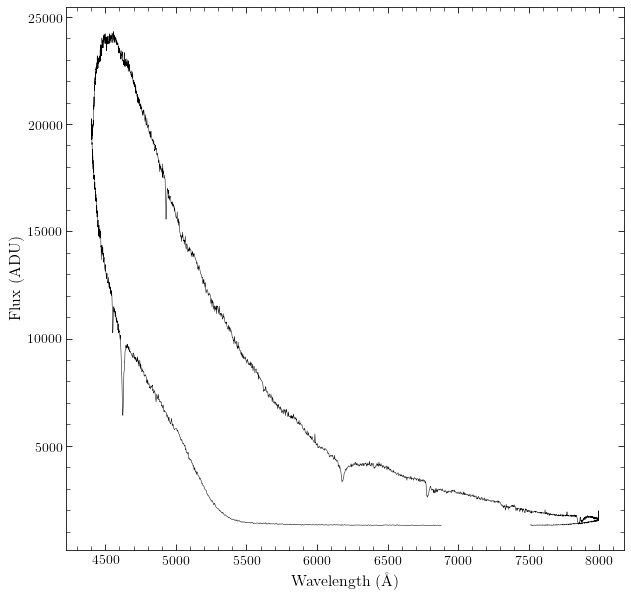

In [37]:
# apply to target
name_target = 'spectrum_raw.dat'
file_target = path.join(filepath, name_target)
spectrum_target = ascii.read(file_target)
pix_target, flux_target = spectrum_target['col1'], spectrum_target['col2']

wave_target = fitfunc(pix_target)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(wave_target, flux_target, color='black', linewidth=0.5)
ax.set_xlabel('Wavelength (\\AA)')
ax.set_ylabel('Flux (ADU)')

Notice that this was a very bad fit. 

**This is why you need to use lines in the largest possible range, to avoid Runge's phenomenon!**